In [1]:
import pickle
import torch
import os 
import numpy as np

os.chdir('/home/sarvagya/SEG-rc/')
BASE_DIR = 'results/attn_maps'
blur_regions = 'begin)'
seg_applied_layers = 'mid'
seg_blur_sigma = 10
seg_scale = 3
guidance_scale = 0

In [59]:
# file = os.path.join(BASE_DIR, f'blur_regions-{blur_regions}/seg_applied_layers-{seg_applied_layers}/seg_blur_sigma-{seg_blur_sigma}_seg_scale-{seg_scale}_guidance_scale-{guidance_scale}.pkl')
file='results/attn_maps/blur_regions-begin)/seg_applied_layers-mid/seg_blur_sigma-10_seg_scale-3_guidance_scale-0.pkl'
with open(file, 'rb') as f:
    data = pickle.load(f)
    
# Compute total size in bytes
total_size_bytes = sum(arr.nbytes for arr in data['up'][0])
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of data['up'][0]: {total_size_bytes} bytes ({total_size_mb:.2f} MB)")
data['up'][0].dtype, data['up'][1].shape
data['up'][0].shape

Total size of data['up'][0]: 4194304 bytes (4.00 MB)


(2, 1024, 1024)

In [60]:
len(data['up'])

30

In [57]:
attn_map = data['down'][0][0]
# normalise the attention map
attn_map = (attn_map - np.min(attn_map)) / (np.max(attn_map) - np.min(attn_map))
print(np.min(attn_map), np.max(attn_map), attn_map.shape)

# plot attention_map
import matplotlib.pyplot as plt
import numpy as np

# there is 1 channels in the attention map, plot them seperately... also add a colorbar
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(attn_map, cmap='hot')
plt.colorbar(ax.imshow(attn_map, cmap='hot'), ax=ax)

IndexError: list index out of range

In [4]:
# create a key, query vector and value vector using np.randn
key = np.random.randn(3, 2, 3, 10, 1024, 64).astype(np.float32)

# estimate total space needed for key, query and value
total_size_bytes = sum(key.nbytes for key in [key])
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of key, query and value: {total_size_bytes} bytes ({total_size_mb:.2f} MB)")

Total size of key, query and value: 47185920 bytes (45.00 MB)


In [5]:
import numpy as np
import os
import blosc
import time

# Set parameters
num_files = 10
shape = (3, 2, 3, 10, 1024, 64)  # Given shape
dtype = np.float32
data_dir = "test_data"

# Create directory
os.makedirs(data_dir, exist_ok=True)

# Step 1: Generate 10 .npy files
file_paths = []
original_sizes = []

print("Generating .npy files...")
for i in range(num_files):
    array = np.random.randn(*shape).astype(dtype)  # Create array
    file_path = os.path.join(data_dir, f"file_{i}.npy")
    np.save(file_path, array)  # Save as .npy
    file_paths.append(file_path)

# Step 2: Get size of each .npy file
print("\nOriginal File Sizes:")
for file_path in file_paths:
    size = os.path.getsize(file_path) / (1024**2)  # Convert to MB
    original_sizes.append(size)
    print(f"{file_path}: {size:.2f} MB")

total_original_size = sum(original_sizes)
print(f"\nTotal Original Size: {total_original_size:.2f} MB")

# Step 3: Compress using Blosc (zstd)
blosc_compressed_size = 0
compressed_files = []

print("\nCompressing with Blosc...")
for i, file_path in enumerate(file_paths):
    with open(file_path, "rb") as f:
        raw_data = f.read()  # Read raw bytes

    compressed_data = blosc.compress(raw_data, typesize=4, cname="zstd", clevel=5)
    compressed_file_path = file_path.replace(".npy", ".blosc")
    with open(compressed_file_path, "wb") as f:
        f.write(compressed_data)  # Save compressed file
    compressed_files.append(compressed_file_path)

    size = os.path.getsize(compressed_file_path) / (1024**2)  # Convert to MB
    blosc_compressed_size += size
    print(f"{compressed_file_path}: {size:.2f} MB")

print(f"\nTotal Blosc Compressed Size: {blosc_compressed_size:.2f} MB")
print(f"Compression Ratio (Blosc): {(blosc_compressed_size / total_original_size) * 100:.2f}%")

# Step 4: Compress using .npz
npz_file_path = os.path.join(data_dir, "dataset.npz")
np.savez_compressed(npz_file_path, **{f"array_{i}": np.load(f) for i, f in enumerate(file_paths)})

npz_compressed_size = os.path.getsize(npz_file_path) / (1024**2)  # Convert to MB
print(f"\nTotal .npz Compressed Size: {npz_compressed_size:.2f} MB")
print(f"Compression Ratio (.npz): {(npz_compressed_size / total_original_size) * 100:.2f}%")


Generating .npy files...

Original File Sizes:
test_data/file_0.npy: 45.00 MB
test_data/file_1.npy: 45.00 MB
test_data/file_2.npy: 45.00 MB
test_data/file_3.npy: 45.00 MB
test_data/file_4.npy: 45.00 MB
test_data/file_5.npy: 45.00 MB
test_data/file_6.npy: 45.00 MB
test_data/file_7.npy: 45.00 MB
test_data/file_8.npy: 45.00 MB
test_data/file_9.npy: 45.00 MB

Total Original Size: 450.00 MB

Compressing with Blosc...
test_data/file_0.blosc: 39.05 MB
test_data/file_1.blosc: 39.07 MB
test_data/file_2.blosc: 39.05 MB
test_data/file_3.blosc: 39.06 MB
test_data/file_4.blosc: 39.07 MB
test_data/file_5.blosc: 39.07 MB
test_data/file_6.blosc: 39.05 MB
test_data/file_7.blosc: 39.06 MB
test_data/file_8.blosc: 39.07 MB
test_data/file_9.blosc: 39.05 MB

Total Blosc Compressed Size: 390.61 MB
Compression Ratio (Blosc): 86.80%

Total .npz Compressed Size: 416.78 MB
Compression Ratio (.npz): 92.62%


In [3]:
import numpy as np
import os
import blosc

# Set parameters
num_files = 5
shape = (3, 2, 3, 10, 1024, 64)  # Given shape
dtype = np.float32
data_dir = "test_data"

# Create directory
os.makedirs(data_dir, exist_ok=True)

# Step 1: Generate and save 10 .npy files
file_paths = []
original_sizes = []

print("Generating .npy files...")
for i in range(num_files):
    array = np.random.randn(*shape).astype(dtype)  # Create array
    file_path = os.path.join(data_dir, f"file_{i}.npy")
    np.save(file_path, array)  # Save as .npy
    file_paths.append(file_path)

# Step 2: Get total size of .npy files
total_original_size = sum(os.path.getsize(f) for f in file_paths) / (1024**2)  # Convert to MB
print(f"\nTotal Original Size: {total_original_size:.2f} MB")

# Step 3: Compress all `.npy` files into a single `.npz`
npz_file_path = os.path.join(data_dir, "dataset.npz")
np.savez_compressed(npz_file_path, **{f"array_{i}": np.load(f) for i, f in enumerate(file_paths)})

npz_compressed_size = os.path.getsize(npz_file_path) / (1024**2)  # Convert to MB
print(f"\nTotal .npz Compressed Size: {npz_compressed_size:.2f} MB")
print(f"Compression Ratio (.npz): {(npz_compressed_size / total_original_size) * 100:.2f}%")

# Step 4: Compress all `.npy` files using Blosc
blosc_file_path = os.path.join(data_dir, "dataset.blosc")

print("\nCompressing all .npy files into a single Blosc file...")
all_data = b"".join(open(f, "rb").read() for f in file_paths)  # Concatenate binary data
compressed_data = blosc.compress(all_data, typesize=4, cname="zstd", clevel=5)  # Compress
with open(blosc_file_path, "wb") as f:
    f.write(compressed_data)

blosc_compressed_size = os.path.getsize(blosc_file_path) / (1024**2)  # Convert to MB
print(f"\nTotal Blosc Compressed Size: {blosc_compressed_size:.2f} MB")
print(f"Compression Ratio (Blosc): {(blosc_compressed_size / total_original_size) * 100:.2f}%")


Generating .npy files...

Total Original Size: 225.00 MB

Total .npz Compressed Size: 208.39 MB
Compression Ratio (.npz): 92.62%

Compressing all .npy files into a single Blosc file...

Total Blosc Compressed Size: 195.29 MB
Compression Ratio (Blosc): 86.80%


In [27]:
import torch

q = torch.rand(3, 10, 1024, 64).to(torch.float32)
k = torch.rand(3, 10, 1024, 64).to(torch.float32)
q_k_concat = torch.cat([q, k], dim=-1)
q_k_concat.shape


torch.Size([3, 10, 1024, 128])

In [28]:
import torch

# Define the shape
time = 3
tensor_shape = (3, 10 , 1024, 128)  # Assuming attn_heads = 8

# Create a random tensor of float32 type
tensor = torch.randn(tensor_shape, dtype=torch.float32)

# Compute the size in MB
size_in_bytes = tensor.element_size() * tensor.numel()
size_in_mb = size_in_bytes / (1024 ** 2)

print(f"Tensor size in MB: {size_in_mb:.2f} MB")
tensor

Tensor size in MB: 15.00 MB


tensor([[[[-1.4763e+00, -1.1481e+00, -4.2619e-01,  ...,  5.4788e-01,
            7.2583e-01,  7.5741e-01],
          [-1.4074e-01, -3.4327e-01, -1.1126e-01,  ..., -2.3615e-01,
           -7.6915e-01,  8.5350e-01],
          [-9.9904e-01,  6.8988e-01, -1.4231e+00,  ..., -3.4912e-02,
            1.7584e+00,  3.0860e+00],
          ...,
          [-1.6202e-01,  4.6808e-01, -3.3439e-01,  ..., -5.5050e-01,
           -1.3461e+00,  8.0848e-01],
          [-1.8335e+00, -5.3460e-01,  1.3711e+00,  ...,  1.8947e-01,
           -8.7697e-01,  1.6812e+00],
          [ 2.8927e+00, -1.4349e-01,  4.6758e-02,  ...,  4.3161e-01,
            1.2269e+00, -1.3828e+00]],

         [[-9.9370e-01, -1.0452e+00,  9.9549e-01,  ...,  2.6266e-02,
            8.3207e-02,  1.0218e+00],
          [ 1.0395e-02,  6.1667e-01,  9.8468e-01,  ..., -4.2431e-01,
            1.8888e-01, -4.0185e-01],
          [-1.7922e-01,  4.1277e-01, -3.4919e-01,  ...,  5.3523e-02,
           -9.4490e-02,  9.9003e-02],
          ...,
     

In [ ]:
import cv2
import pywt
import numpy as np
import time
import tracemalloc
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread("pics/seed-42/blur_regions-begin___mid___end)/seg_applied_layers-down/guidance_scales-3.png", cv2.IMREAD_GRAYSCALE)

## Gaussian Blur Performance Measurement
tracemalloc.start()  # Start memory tracking
start_gaussian = time.time()
blurred = cv2.GaussianBlur(image, (5, 5), 1)
end_gaussian = time.time()
mem_gaussian = tracemalloc.get_traced_memory()[1]  # Peak memory usage
tracemalloc.stop()

## Wavelet Transform Performance Measurement
tracemalloc.start()  # Start memory tracking
start_wavelet = time.time()
coeffs2 = pywt.dwt2(image, 'haar')  # Wavelet decomposition
LL, (LH, HL, HH) = coeffs2  # Extract low & high-frequency components
image_wavelet = pywt.idwt2((LL, (None, None, None)), 'haar')  # Reconstruct using LL only
end_wavelet = time.time()
mem_wavelet = tracemalloc.get_traced_memory()[1]  # Peak memory usage
tracemalloc.stop()

# Show results
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image, cmap='gray'); axs[0].set_title("Original Image")
axs[1].imshow(blurred, cmap='gray'); axs[1].set_title("Gaussian Blurred")
axs[2].imshow(image_wavelet, cmap='gray'); axs[2].set_title("Wavelet Filtered")

# Print Execution Time & Memory Usage
print(f"Gaussian Blur Time: {end_gaussian - start_gaussian:.6f} sec")
print(f"Wavelet Transform Time: {end_wavelet - start_wavelet:.6f} sec")
print(f"Gaussian Blur Memory: {mem_gaussian / 1024:.2f} KB")
print(f"Wavelet Transform Memory: {mem_wavelet / 1024:.2f} KB")


In [8]:
import torch

generator = torch.Generator().manual_seed(721)
print(generator.seed())

5867991739709137916


In [5]:
import numpy as np

file = "results/metrics/seed-97-time-stitched/segSigma_10__segScale_3__guidanceScale_5/segAppliedLayers_(down_up)/blurRegions_(begin_mid_end)/up_block-1_concatenated.npy"

# Load the numpy array
data = np.load(file, allow_pickle=True)[:,0,:,:,:]
data.shape

(10, 20, 1024, 8)

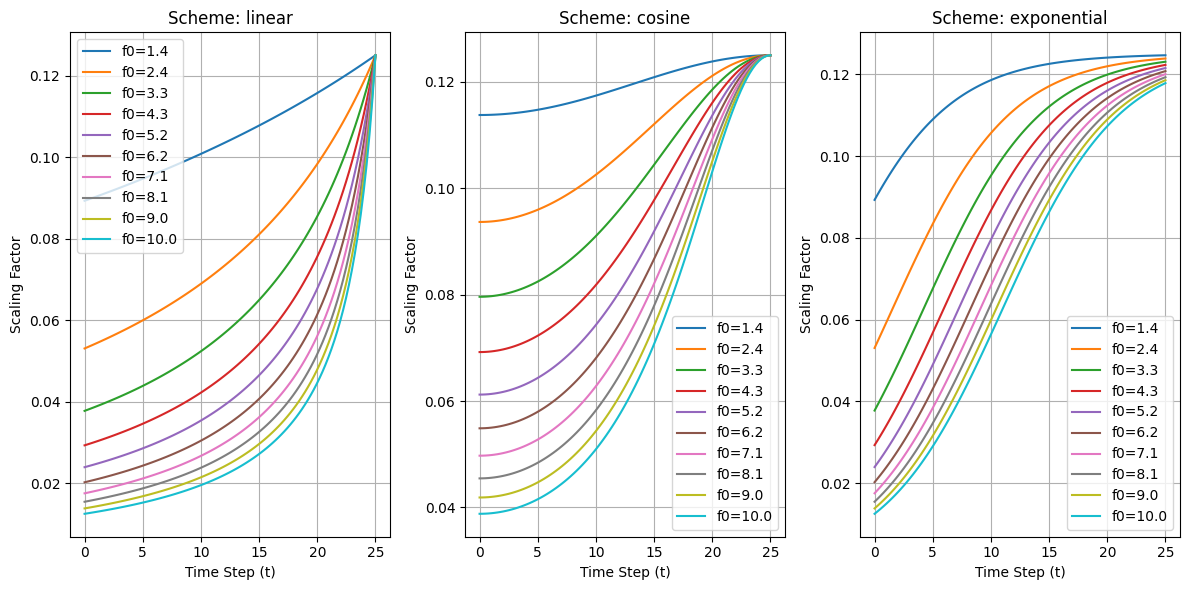

0.125


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define the time-dependent scaling function
def time_dependent_scaling(t, T, dim, scheme="linear", f0=1.5, **kwargs):
    t = max(0.0, min(t, T))  # Clamp t

    if scheme == "linear":
        f_t = 1 + (f0 - 1) * (1 - t / T)
    elif scheme == "cosine":
        f_t = 1 + (f0 - 1) * 0.1234* (1 + math.cos(math.pi * t / T))
    elif scheme == "exponential":
        lambda_ = kwargs.get("lambda_", 5)
        f_t = 1 + (f0 - 1) * math.exp(-lambda_ * t / T)
    else:
        raise ValueError(f"Unknown scheme: {scheme}")

    return (math.sqrt(dim) * f_t)**-1

# Parameters
T = 25
dim = 64  # Example embedding dimension
schemes = ["linear", "cosine", "exponential"]
f0_values = np.linspace(1.4, 10, 10)  # Values of f0 in range [2, 10]

# Generate plots
t_values = np.linspace(0, T, 100)

plt.figure(figsize=(12, 6))

for scheme in schemes:
    plt.subplot(1, 3, schemes.index(scheme) + 1)
    for f0 in f0_values:
        scaling_factors = [time_dependent_scaling(t, T, dim, scheme, f0) for t in t_values]
        plt.plot(t_values, scaling_factors, label=f"f0={f0:.1f}")
    
    plt.title(f"Scheme: {scheme}")
    plt.xlabel("Time Step (t)")
    plt.ylabel("Scaling Factor")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
print(1/8)


In [ ]:
import torch
import torch.nn.functional as F
import time
import psutil
import os

def compute_integral_image_for_kernel(x: torch.Tensor, k: int) -> torch.Tensor:
    """Compute the integral image for x (B, C, T, E, D) using a box filter of size k."""
    half_k = k // 2
    B, C, T, E, D = x.shape
    N = B * C * T
    x_flat = x.contiguous().view(N, E, D)

    # Pad using 'constant' mode, which is generally faster than 'replicate'
    x_padded = F.pad(x_flat, pad=(half_k, half_k, half_k, half_k), mode='constant', value=0)

    E_p, D_p = E + 2 * half_k, D + 2 * half_k
    S_flat = x_padded.new_zeros((N, E_p + 1, D_p + 1))

    # Compute integral image using in-place cumulative sum
    torch.cumsum(x_padded, dim=1, out=S_flat[:, 1:, 1:])
    torch.cumsum(S_flat[:, 1:, 1:], dim=2, out=S_flat[:, 1:, 1:])

    return S_flat.view(B, C, T, E_p + 1, D_p + 1)

def compute_box_blur(x: torch.Tensor, k: int) -> torch.Tensor:
    """Compute the box-blur image using the integral image method."""
    half_k = k // 2
    S = compute_integral_image_for_kernel(x, k)  # Shape (B, C, T, E+2*half_k+1, D+2*half_k+1)
    B, C, T, S_E, S_D = S.shape
    _, _, _, E, D = x.shape

    # Box filter sum calculation
    bottom_right = S[..., half_k + 1 : half_k + 1 + E, half_k + 1 : half_k + 1 + D]
    top_right = S[..., half_k + 1 : half_k + 1 + E, :-k]
    bottom_left = S[..., :-k, half_k + 1 : half_k + 1 + D]
    top_left = S[..., :-k, :-k]

    # Compute average for each k×k region
    return (bottom_right - top_right - bottom_left + top_left) / (k * k)

def interpolated_box_blur(x: torch.Tensor, k: int, alpha: float) -> torch.Tensor:
    """Interpolates between original image and its box-blurred version."""
    blurred = compute_box_blur(x, k)
    return torch.lerp(x, blurred, alpha)  # Faster than manual linear interpolation

def print_memory_usage():
    """Prints the current process memory usage in MB."""
    process = psutil.Process(os.getpid())
    mem_mb = process.memory_info().rss / (1024 * 1024)
    print(f"Memory usage: {mem_mb:.2f} MB")

# Example usage
if __name__ == '__main__':
    x = torch.randn(3, 20, 20, 1024, 64, dtype=torch.float64, device="cuda")  # Using CUDA if available
    k = 21
    alpha = 0.7

    print_memory_usage()
    start_time = time.time()
    output = interpolated_box_blur(x, k, alpha)
    elapsed = time.time() - start_time

    print("Time taken:", elapsed)
    print("Output shape:", output.shape)
    print_memory_usage()


Memory usage: 593.17 MB
Time taken: 0.0014262199401855469
Output shape: torch.Size([3, 20, 20, 1024, 64])
Memory usage: 593.17 MB
